# Transaction Fraud Detection: Exploratory Data Analysis and Preprocessing

This notebook performs exploratory data analysis (EDA) and preprocessing on the IEEE Fraud Detection dataset for our Nature-Inspired Computing project. The goal is to understand the data, visualize key features, and prepare it for modeling.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Set plot style
sns.set(style='whitegrid')
%matplotlib inline

In [2]:
# Load and merge datasets
df_identities = pd.read_csv('train_identity.csv')
df_transactions = pd.read_csv('train_transaction.csv')
df = pd.merge(df_transactions, df_identities, on='TransactionID', how='left')

## Basic Data Exploration

In [3]:
# Dataset overview
df.info()
print(f'Number of samples: {df.shape[0]}')
print(f'Number of attributes: {df.shape[1]}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB
Number of samples: 590540
Number of attributes: 434


In [4]:
# Check for duplicates
print('Any duplicates:', df.duplicated().any())

Any duplicates: False


In [5]:
# Check for columns with only one unique value
for col in df.columns:
    if len(df.loc[:, col].dropna().unique()) == 1:
        print(f'Column with single unique value: {col}')

In [6]:
# Data types distribution
print(df.dtypes.value_counts())

float64    399
object      31
int64        4
Name: count, dtype: int64


In [7]:
# Identify categorical columns
columns_object = df.select_dtypes(include=['object']).columns
print('Categorical columns:', columns_object)

Categorical columns: Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15',
       'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33',
       'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo'],
      dtype='object')


## Visualizing Target Variable

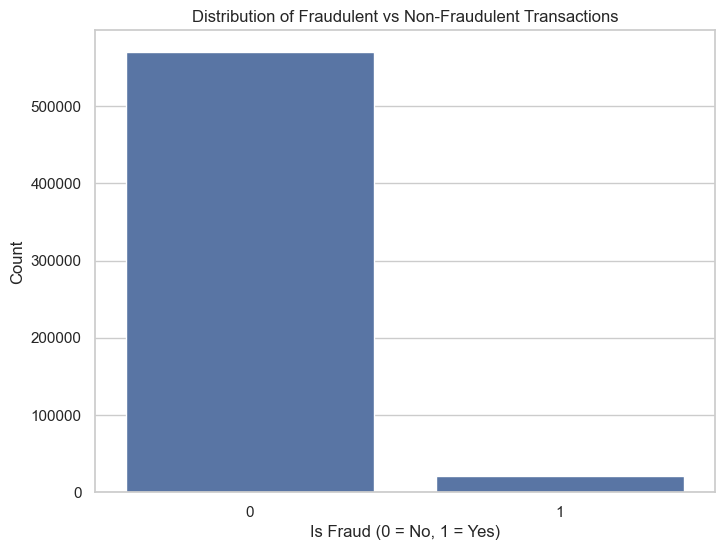

Value counts:
 isFraud
0    569877
1     20663
Name: count, dtype: int64
Percentage:
 isFraud
0    96.500999
1     3.499001
Name: proportion, dtype: float64


In [8]:
# Distribution of isFraud
plt.figure(figsize=(8, 6))
sns.countplot(x='isFraud', data=df)
plt.title('Distribution of Fraudulent vs Non-Fraudulent Transactions')
plt.xlabel('Is Fraud (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.savefig('isFraud_distribution.png')
plt.show()

# Print value counts and percentage
fraud_counts = df['isFraud'].value_counts()
fraud_percent = df['isFraud'].value_counts(normalize=True) * 100
print('Value counts:\n', fraud_counts)
print('Percentage:\n', fraud_percent)

## Feature Visualizations

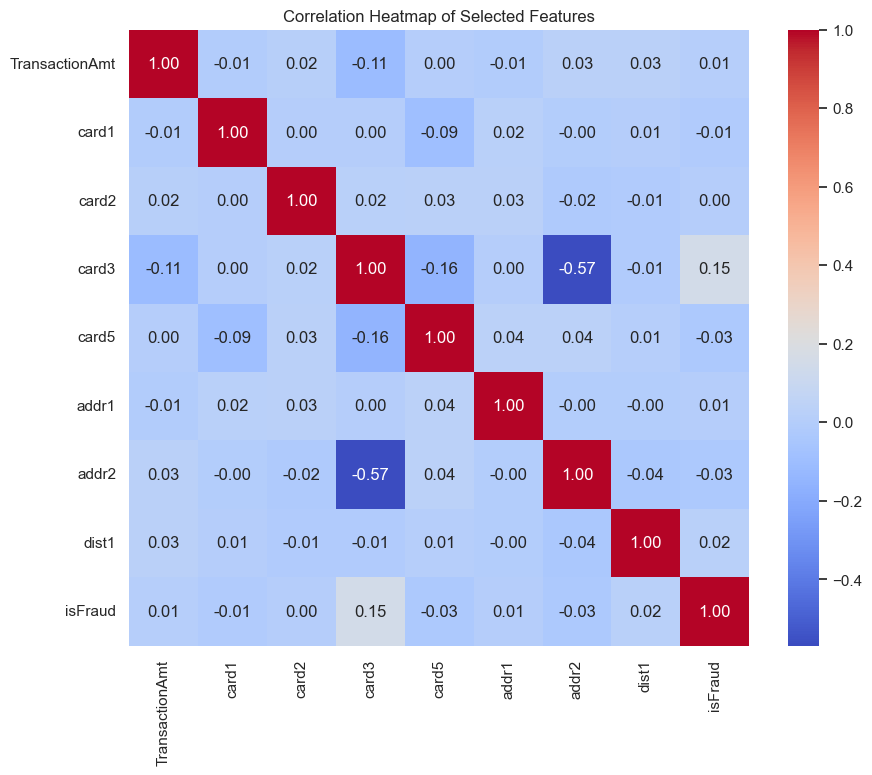

In [9]:
# Correlation heatmap for selected numerical features
# Select features with high correlation to isFraud or based on domain knowledge
selected_features = ['TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'isFraud']
plt.figure(figsize=(10, 8))
sns.heatmap(df[selected_features].corr(), cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlation Heatmap of Selected Features')
plt.savefig('selected_correlation_heatmap.png')
plt.show()

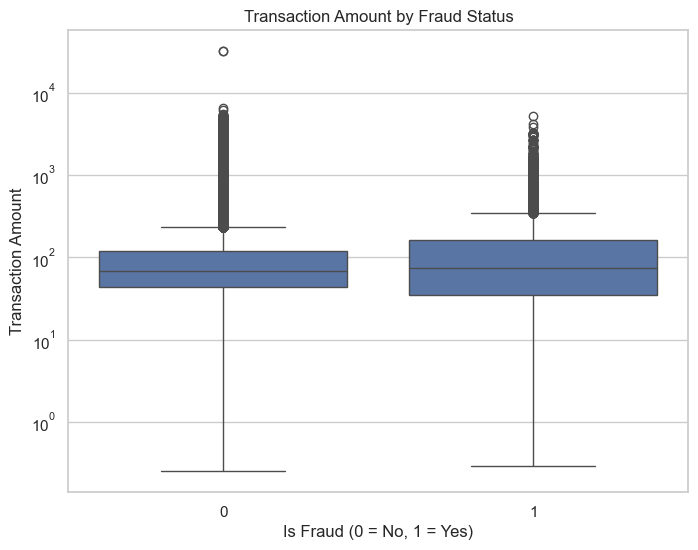

In [10]:
# Box plot for TransactionAmt by isFraud
plt.figure(figsize=(8, 6))
sns.boxplot(x='isFraud', y='TransactionAmt', data=df)
plt.title('Transaction Amount by Fraud Status')
plt.xlabel('Is Fraud (0 = No, 1 = Yes)')
plt.ylabel('Transaction Amount')
plt.yscale('log')  # Log scale due to outliers
plt.savefig('transaction_amt_boxplot.png')
plt.show()

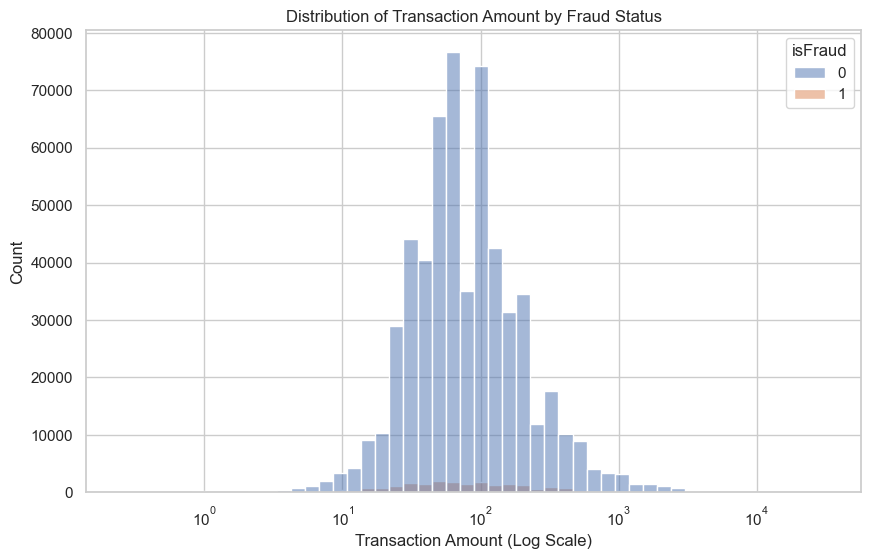

In [11]:
# Histograms for TransactionAmt
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='TransactionAmt', hue='isFraud', bins=50, log_scale=True)
plt.title('Distribution of Transaction Amount by Fraud Status')
plt.xlabel('Transaction Amount (Log Scale)')
plt.ylabel('Count')
plt.savefig('transaction_amt_histogram.png')
plt.show()

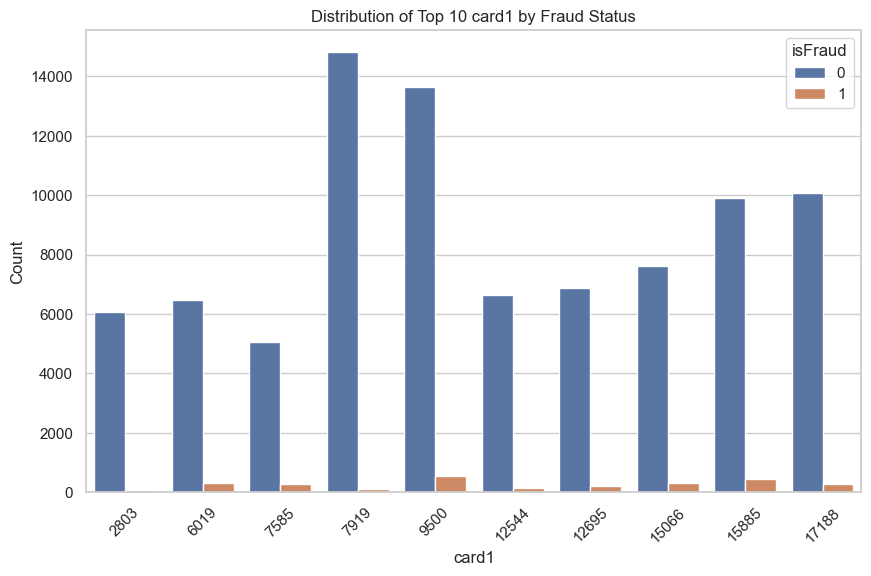

Count of unique values for card1: 13553


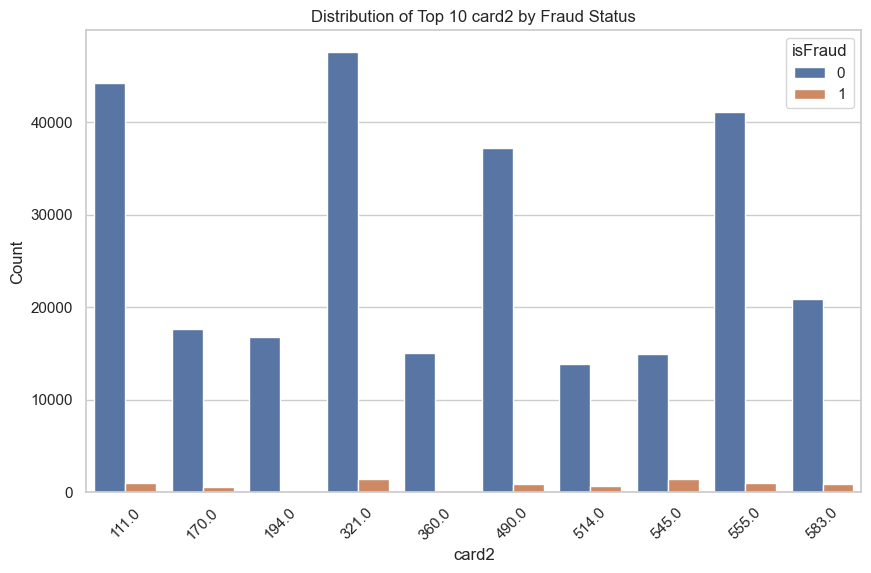

Count of unique values for card2: 501


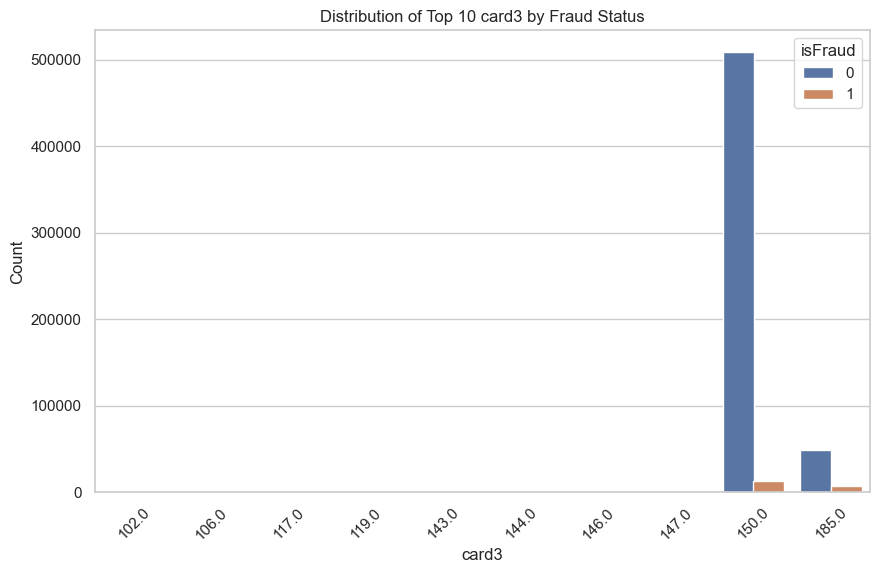

Count of unique values for card3: 115


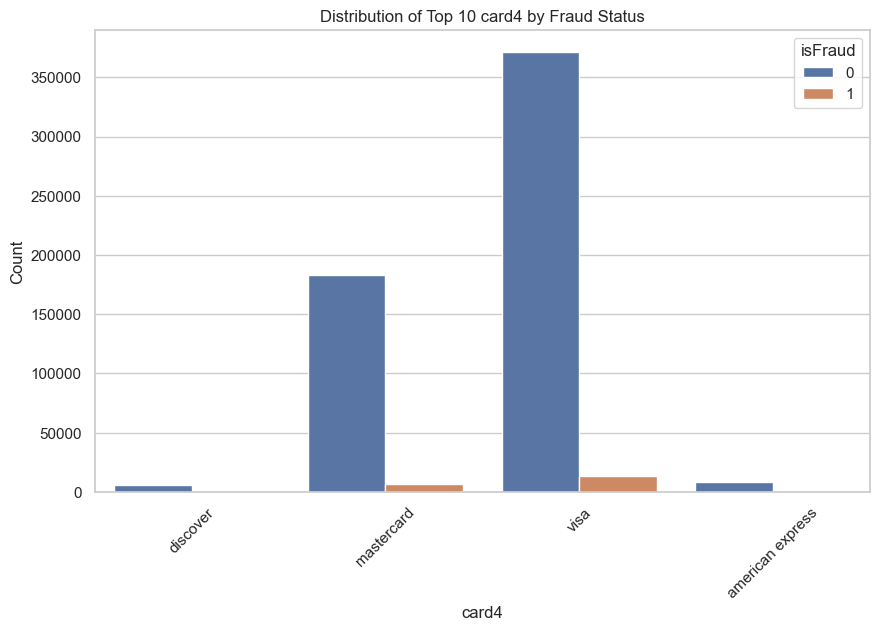

Count of unique values for card4: 5


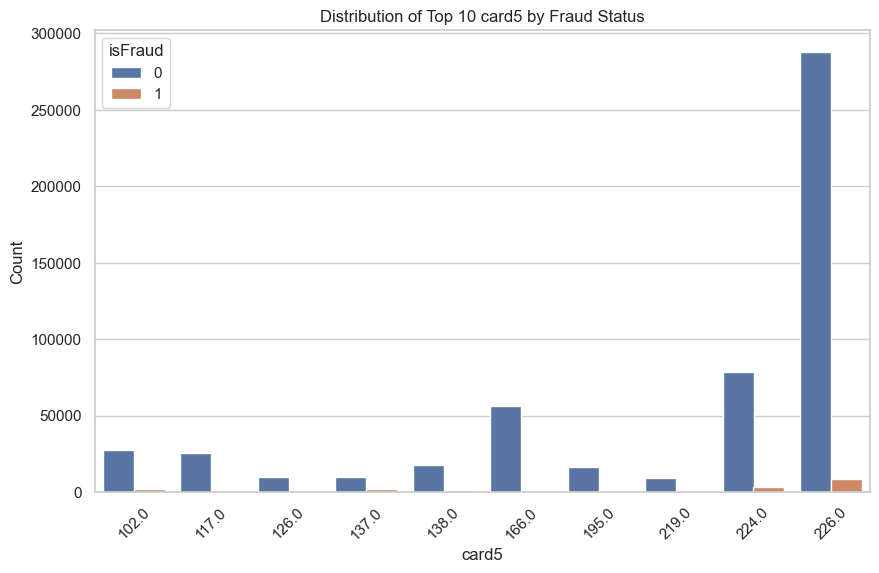

Count of unique values for card5: 120


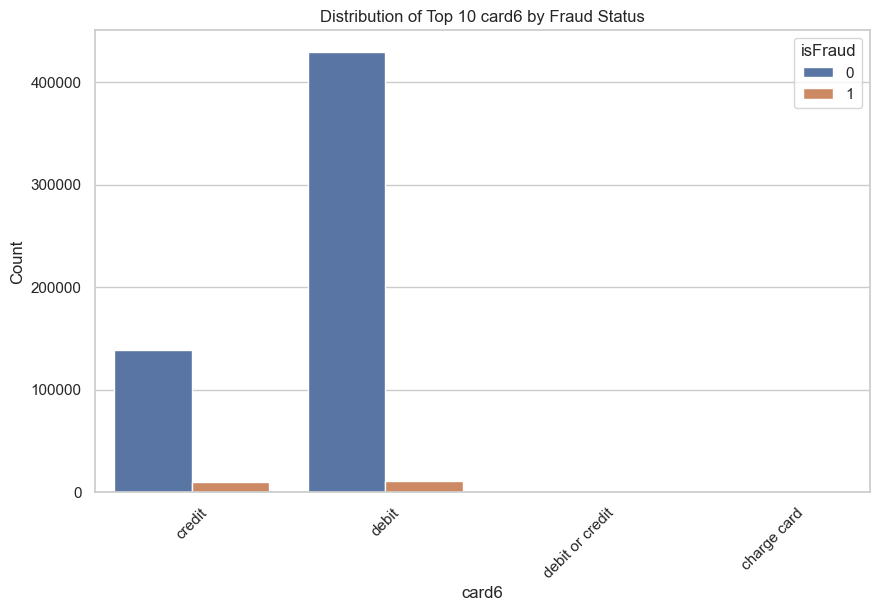

Count of unique values for card6: 5


In [12]:
# Count plots for card features (showing top 10 categories)
for i in range(1, 7):
    top_categories = df[f'card{i}'].value_counts().index[:10]
    plt.figure(figsize=(10, 6))
    sns.countplot(x=f'card{i}', hue='isFraud', data=df[df[f'card{i}'].isin(top_categories)])
    plt.title(f'Distribution of Top 10 card{i} by Fraud Status')
    plt.xlabel(f'card{i}')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.savefig(f'card{i}_top10_countplot.png')
    plt.show()
    print(f'Count of unique values for card{i}: {len(df[f"card{i}"].unique())}')

## Email Domain Transformation and Visualization

In [13]:
# Transform email domains
def transform_email(value):
    if pd.isna(value):
        return 'unknown'
    return value.split('.')[0]

email_attributes = ['P_emaildomain', 'R_emaildomain']
for email_attribute in email_attributes:
    df[f'{email_attribute}_transformed'] = df[email_attribute].apply(lambda x: transform_email(x))

# Group rare email domains
for email_col in ['P_emaildomain_transformed', 'R_emaildomain_transformed']:
    counts = df[email_col].value_counts()
    rare_domains = counts[counts < 100].index
    df[email_col] = df[email_col].apply(lambda x: 'other' if x in rare_domains else x)

print('Unique P_emaildomain_transformed:', len(df.P_emaildomain_transformed.unique()))
print('Unique R_emaildomain_transformed:', len(df.R_emaildomain_transformed.unique()))

Unique P_emaildomain_transformed: 43
Unique R_emaildomain_transformed: 26


<Figure size 1200x600 with 0 Axes>

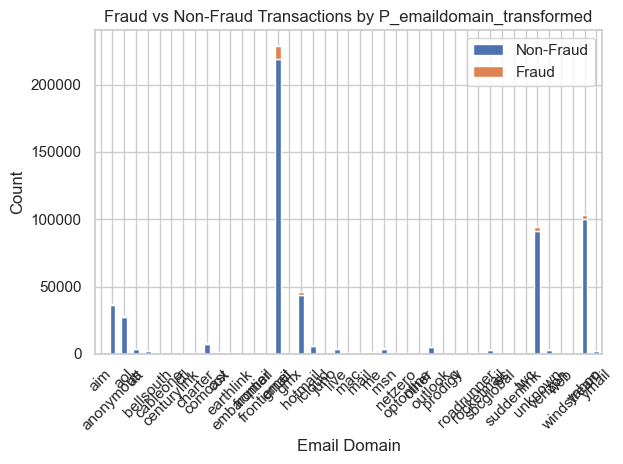

<Figure size 1200x600 with 0 Axes>

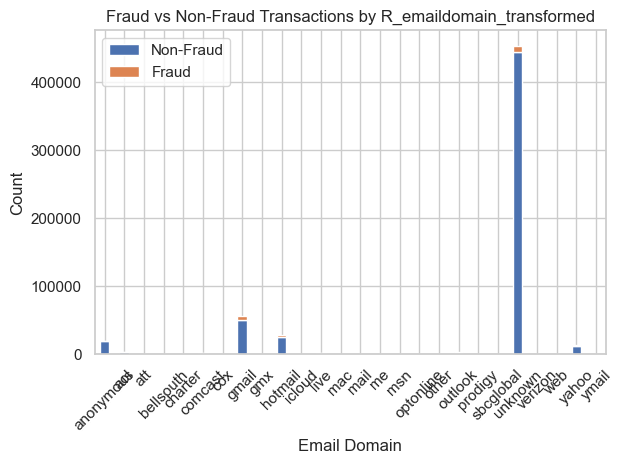

In [14]:
# Stacked bar plots for email domains
for email_col in ['P_emaildomain_transformed', 'R_emaildomain_transformed']:
    plt.figure(figsize=(12, 6))
    email_counts = df.groupby([email_col, 'isFraud']).size().unstack(fill_value=0)
    email_counts.plot(kind='bar', stacked=True)
    plt.title(f'Fraud vs Non-Fraud Transactions by {email_col}')
    plt.xlabel('Email Domain')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(['Non-Fraud', 'Fraud'])
    plt.tight_layout()
    plt.savefig(f'{email_col}_stacked_bar.png')
    plt.show()

## Preprocessing

In [ ]:
# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('isFraud')
categorical_cols = df.select_dtypes(include=['object']).columns

# Define preprocessing pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine pipelines
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])

# Fit and transform the data
df_preprocessed = preprocessor.fit_transform(df)

# Get feature names after preprocessing
feature_names = list(numerical_cols) + list(preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_cols))

# Create preprocessed DataFrame
df_preprocessed = pd.DataFrame(df_preprocessed, columns=feature_names)
df_preprocessed['isFraud'] = df['isFraud'].values

In [ ]:
# Verify preprocessing
print('Missing values after preprocessing:', df_preprocessed.isna().sum().sum())
print('Shape after preprocessing:', df_preprocessed.shape)

## Summary of EDA Findings

- The dataset is highly imbalanced, with fraud cases being rare.
- Transaction amounts show different distributions for fraud and non-fraud cases.
- Certain email domains are associated with higher fraud rates.
- Card features have many unique values; focusing on top categories reveals patterns.

## Next Steps

- Implement feature selection using nature-inspired algorithms.
- Address class imbalance (e.g., oversampling, SMOTE).
- Train and evaluate machine learning models.